In [36]:
import os
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras

In [37]:
# Paths to images and labels
data_dir = r"C:\Users\Eman\Downloads\images-20250217T060743Z-001\images"
labels_dir = r"C:\Users\Eman\Downloads\labels-20250217T060744Z-001\labels"


In [28]:
# Load TIFF images (12-band) and apply min-max normalization
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (12, 128, 128)
        image = np.transpose(image, (1, 2, 0))  # Convert to (128, 128, 12)

    # Min-max normalization per channel
    min_val = np.min(image, axis=(0, 1), keepdims=True)
    max_val = np.max(image, axis=(0, 1), keepdims=True)
    
    # Avoid division by zero
    normalized_image = (image - min_val) / (max_val - min_val + 1e-7)
    
    return normalized_image


In [29]:
# Normalize label images
def load_label(label_path):
    label = tf.keras.preprocessing.image.load_img(label_path, color_mode="grayscale")
    label = np.array(label, dtype=np.uint8)  # Convert to numpy array
    label = (label > 0).astype(np.int32)  # Ensure binary format
    return label

In [30]:
# Get sorted lists of image and label file paths
image_paths = sorted(glob(os.path.join(data_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(labels_dir, "*.png")))

# Debugging: Print number of images and labels
print(f"Total Images: {len(image_paths)}")
print(f"Total Labels: {len(label_paths)}")

# Ensure the number of images matches the number of labels
if len(image_paths) != len(label_paths):
    print("Error: Mismatch between images and labels!")
    exit()


Total Images: 306
Total Labels: 306


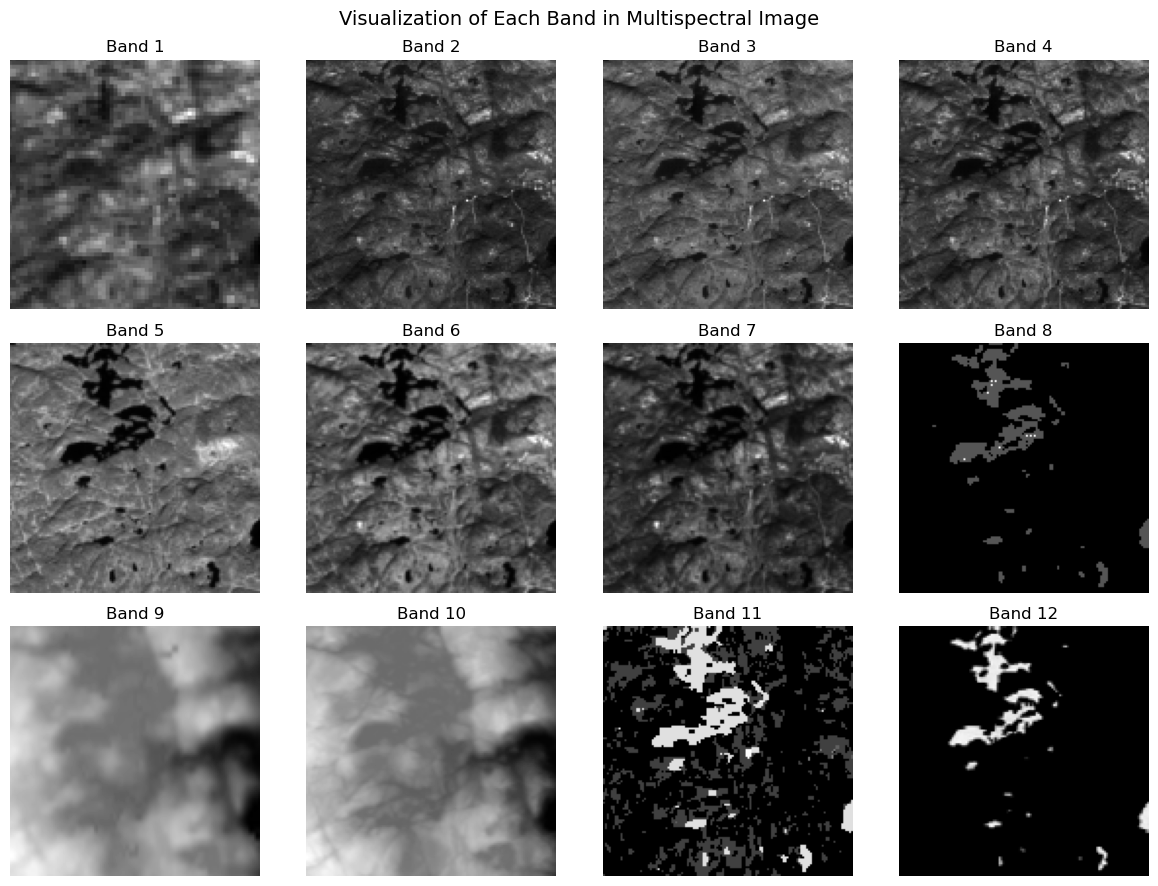

In [31]:
# Visualizing Each Band of a Sample Image
sample_image_path = image_paths[0]

with rasterio.open(sample_image_path) as src:
    sample_image = src.read().astype(np.float32)  # Shape: (12, 128, 128)

# Plot each band separately
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle("Visualization of Each Band in Multispectral Image", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < sample_image.shape[0]:  # Ensure within 12 bands
        ax.imshow(sample_image[i], cmap='gray')
        ax.set_title(f'Band {i+1}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Split dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

print(f"Training Samples: {len(train_images)}, Testing Samples: {len(test_images)}")


Training Samples: 244, Testing Samples: 62


In [33]:
# Build U-Net model
def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (Contracting Path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.5)(p1)  # Dropout to prevent overfitting

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.5)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder (Expanding Path)
    u1 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    #u1 = layers.Dropout(0.5)(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    #u2 = layers.Dropout(0.5)(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [34]:
# Initialize model
model = build_unet()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_4[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_5[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │    295,040 │ conv2d_23[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 128, 128,  │     73,792 │ conv2d_24[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_5[0]

 Total params: 1,888,321 (7.20 MB)

 Trainable params: 1,888,321 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Prepare dataset for training
def preprocess_data(image_paths, label_paths):
    images = np.array([load_image(p) for p in image_paths])
    labels = np.array([load_label(p) for p in label_paths])
    labels = np.expand_dims(labels, axis=-1)  # Add channel dimension
    return images, labels

train_images_np, train_labels_np = preprocess_data(train_images, train_labels)
test_images_np, test_labels_np = preprocess_data(test_images, test_labels)

In [24]:
# Train model
model.fit(train_images_np, train_labels_np, epochs=30, batch_size=8, validation_data=(test_images_np, test_labels_np))


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - accuracy: 0.7910 - loss: 0.5436 - val_accuracy: 0.9050 - val_loss: 0.2612
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 942ms/step - accuracy: 0.8982 - loss: 0.2782 - val_accuracy: 0.9080 - val_loss: 0.2567
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 667ms/step - accuracy: 0.8968 - loss: 0.2942 - val_accuracy: 0.9122 - val_loss: 0.2339
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - accuracy: 0.9063 - loss: 0.2599 - val_accuracy: 0.9128 - val_loss: 0.2251
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8920 - loss: 0.2690 - val_accuracy: 0.9150 - val_loss: 0.2153
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 863ms/step - accuracy: 0.9087 - loss: 0.2385 - val_accuracy: 0.9169 - val_loss: 0.2148
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 837ms/step - accuracy: 0.8997 - loss: 0.2565 - val_accuracy: 0.9123 - val_loss: 0.2479
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 556ms/step - accuracy: 0.9000 - loss: 0.2519 - val_accurac

In [25]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    iou = MeanIoU(num_classes=2)
    iou.update_state(y_true, y_pred)
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    
    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / \
               (precision.result().numpy() + recall.result().numpy() + 1e-7)
    
    print(f"IoU: {iou.result().numpy():.4f}, Precision: {precision.result().numpy():.4f}, "
          f"Recall: {recall.result().numpy():.4f}, F1-score: {f1_score:.4f}")

In [26]:
# Predict and evaluate
predictions = (model.predict(test_images_np) > 0.5).astype(np.int32)
evaluate_model(test_labels_np, predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
IoU: 0.8369, Precision: 0.9120, Recall: 0.8064, F1-score: 0.8560


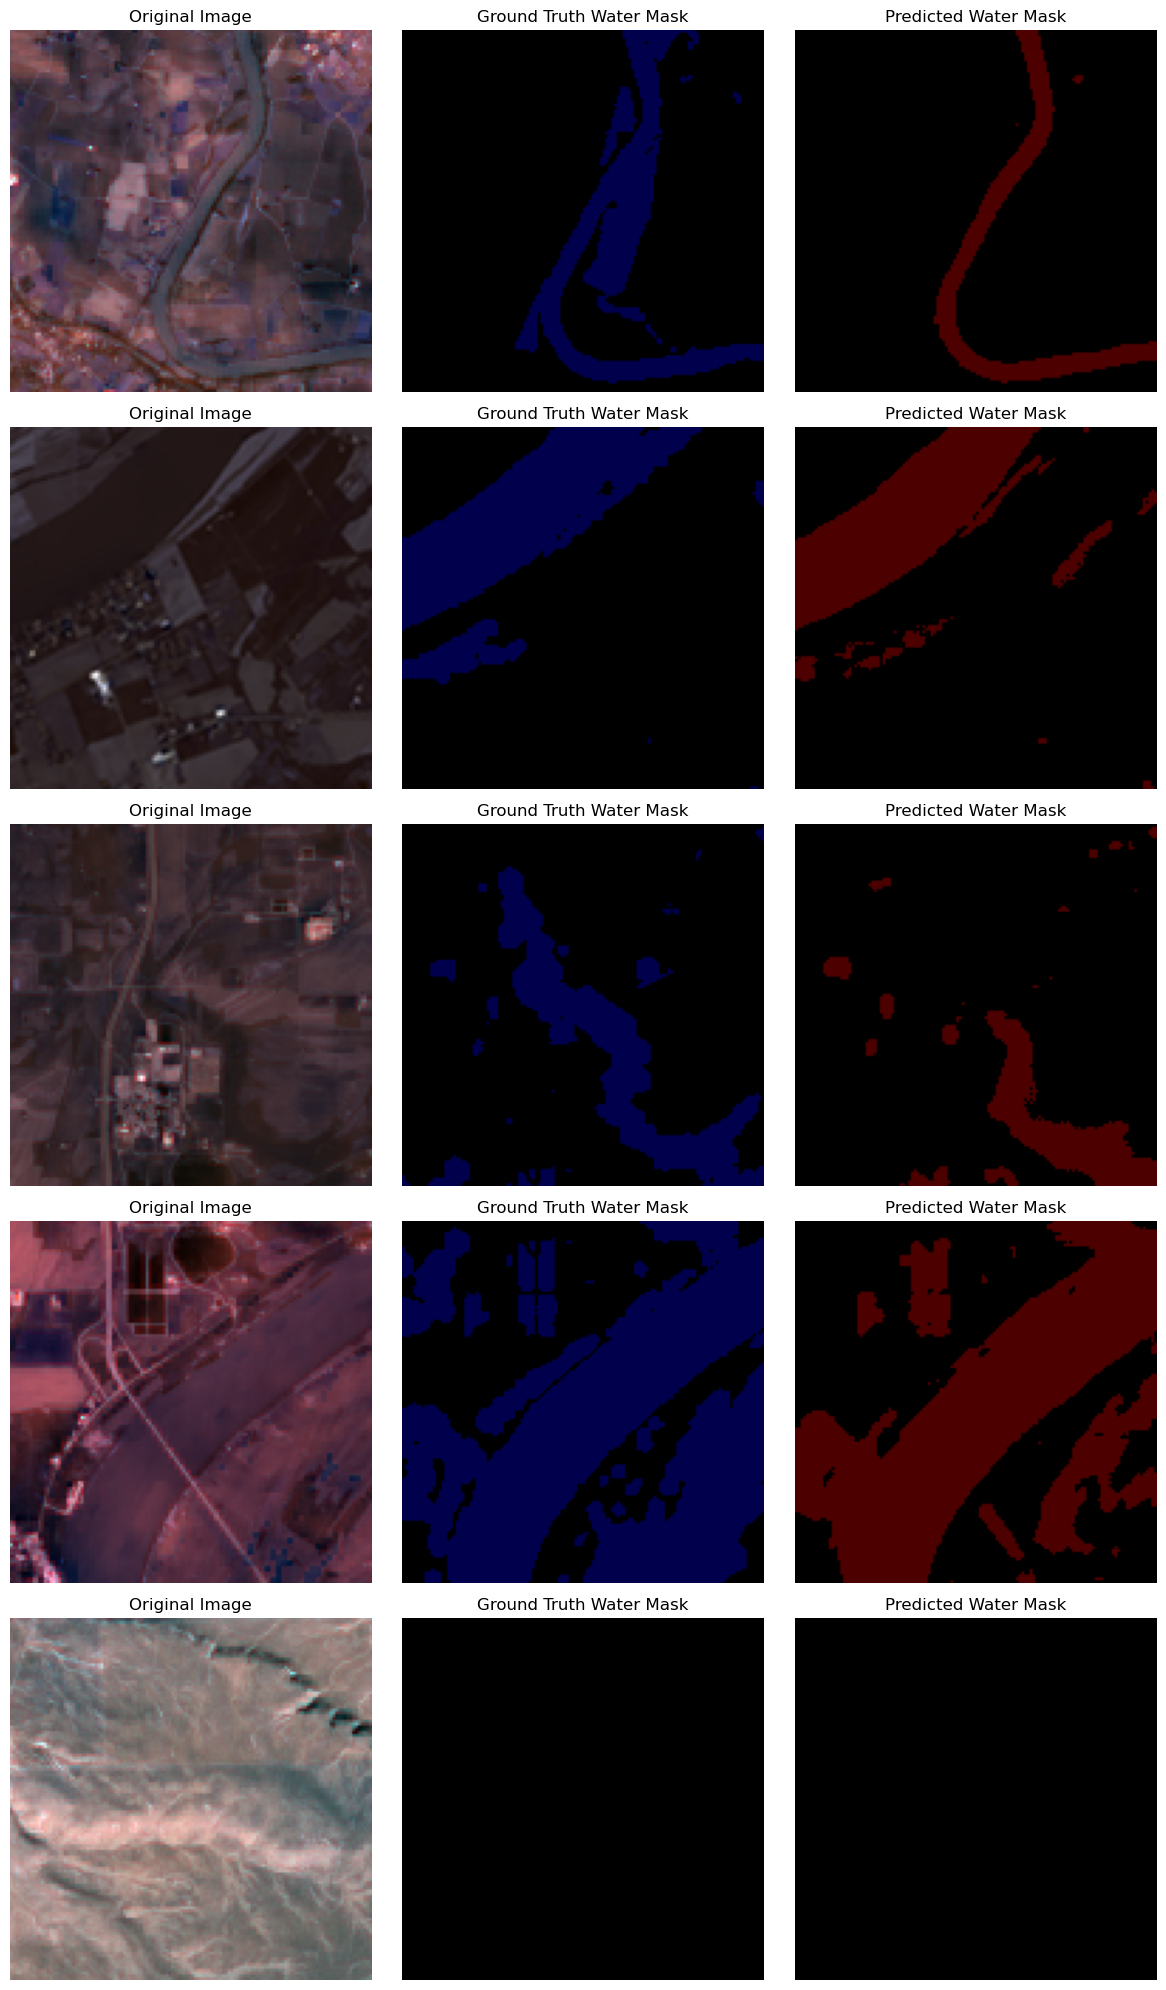

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_water_segmentation(test_images, test_labels, predictions, num_samples=5):
    plt.figure(figsize=(12, num_samples * 4))

    for i in range(num_samples):
        img = test_images[i][:, :, :3]  # Use the first 3 bands as RGB approximation
        true_mask = test_labels[i].squeeze()  # Ground truth binary mask
        pred_mask = predictions[i].squeeze()  # Model prediction binary mask

        # Ensure masks are binary (0 or 1)
        true_mask = (true_mask > 0.5).astype(np.uint8)
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Create overlay masks
        true_overlay = np.zeros_like(img, dtype=np.uint8)
        pred_overlay = np.zeros_like(img, dtype=np.uint8)

        # Blue for ground truth, Red for predicted water regions
        true_overlay[true_mask == 1] = [0, 0, 255]  
        pred_overlay[pred_mask == 1] = [255, 0, 0]  

        # Blend with original image
        overlay_true = cv2.addWeighted(img.astype(np.uint8), 0.7, true_overlay, 0.3, 0)
        overlay_pred = cv2.addWeighted(img.astype(np.uint8), 0.7, pred_overlay, 0.3, 0)

        # Plot images
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(overlay_true)
        plt.title("Ground Truth Water Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(overlay_pred)
        plt.title("Predicted Water Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_water_segmentation(test_images_np, test_labels_np, predictions, num_samples=5)
